In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlalchemy
from sklearn import preprocessing, cluster, metrics
%matplotlib inline

In [5]:
conn  = sqlalchemy.create_engine('postgresql:///yelp')

In [9]:
def reader( data ):
# read the entire file into a python array

    # remove the trailing "\n" from each line
    data = map(lambda x: x.rstrip(), data)

    # each element of 'data' is an individual JSON object.
    # i want to convert it into an *array* of JSON objects
    # which, in and of itself, is one large JSON object
    # basically... add square brackets to the beginning
    # and end, and have all the individual business JSON objects
    # separated by a comma
    data_json_str = "[" + ','.join(data) + "]"

    # now, load it into pandas
    return pd.read_json(data_json_str)


Read in the review dataset

In [ ]:
data = open('./data/yelp_academic_dataset_review.json').readlines()
step = range(0,len(data),100000)
i=0
while i < len(step):
    if i%10 == 0: print step[i], 'to', step[i+1]
    df = reader(data[step[i]:step[i+1]])
    print df.head()
    df[['user_id', 'business_id','date','stars']].to_sql('reviews',conn, if_exists='append')
    i+=1



Read in the business dataset

In [14]:
data = open('./data/yelp_academic_dataset_business.json').readlines()
df = reader( data )
price = df[df.attributes.apply(lambda x: 'Price Range' in x.keys() )]
price['cost'] = price.attributes.apply(lambda x: x['Price Range'] )
price[['business_id','review_count','stars','cost']].to_sql('business',conn, if_exists='append')

Read in the reviwer dataset

In [11]:
data = open('./data/yelp_academic_dataset_user.json').readlines()
df = reader( data )
df[['user_id','average_stars']].to_sql('person',conn, if_exists='append')

### Now compare reviewer averages with business averages

In [17]:
queryString = """

SELECT t1.uid, t1.theReview, t1.avgPerRev, b.stars as avgBusRev, b.cost
FROM

(SELECT p.average_stars as avgPerRev, r.stars as theReview, r.business_id, p.user_id as uid
FROM reviews as r
INNER JOIN person as p
ON p.user_id = r.user_id ) as t1

INNER JOIN business as b
ON t1.business_id = b.business_id

"""


In [18]:
review_data = pd.read_sql_query(queryString, conn)

In [22]:
review_data.head()

,uid,thereview,avgperrev,avgbusrev,cost
0,pEVf8GRshP9HUkSpizc9LA,2,3.96,4.0,2
1,uZbTb-u-GVjTa2gtQfry5g,4,3.85,4.0,2
2,HOaWRV72ZQs0me1geSqBzg,5,3.93,5.0,1
3,pEVf8GRshP9HUkSpizc9LA,4,3.96,3.5,2
4,Mn9YYbeY_ydJ7NABALyYIQ,2,3.42,3.5,2


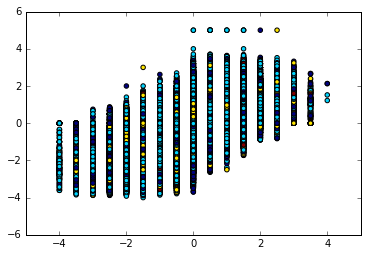

In [33]:
plt.scatter( review_data.thereview - review_data.avgbusrev,
             review_data.thereview - review_data.avgperrev,
             c = review_data.cost
           )

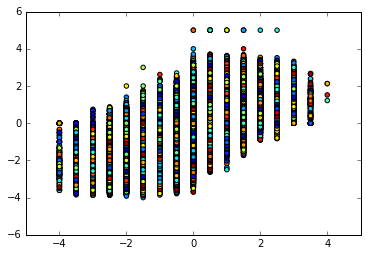

In [34]:
plt.scatter( review_data.thereview - review_data.avgbusrev,
             review_data.thereview - review_data.avgperrev,
             c = preprocessing.LabelEncoder().fit_transform( review_data.uid )
           )

In [35]:
review_data.groupby('uid').agg({'thereview':len}).describe()

,thereview
count,490728.000000
mean,3.913382
std,13.035267
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,1189.000000


## Think about using users to seed database

In [96]:
queryString = """
SELECT avg(b.stars) as avgReview, stddev(b.stars) as stdReview, 
       avg(b.cost) as avgCost,  stddev(b.cost) as stdCost 
FROM

(SELECT r.stars as theReview, r.business_id, p.user_id as uid
FROM reviews as r
INNER JOIN person as p
ON p.user_id = r.user_id) jn1

INNER JOIN business as b
ON jn1.business_id = b.business_id

GROUP BY jn1.uid
HAVING COUNT(jn1.theReview) > 10;
"""

In [97]:
df = pd.read_sql_query(queryString,conn)

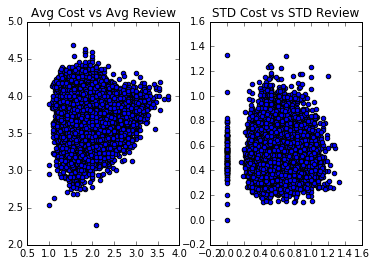

In [98]:
plt.subplot(121)
plt.title('Avg Cost vs Avg Review')
plt.scatter(df.avgcost, df.avgreview)
plt.subplot(122)
plt.title('STD Cost vs STD Review')
plt.scatter(df.stdcost, df.stdreview)

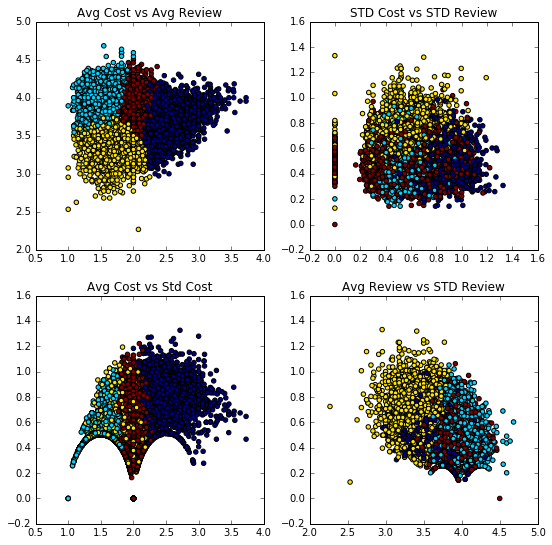

In [99]:
clst = cluster.k_means(df, 4)

plt.figure(figsize=(9,9))
plt.subplot(221)
plt.title('Avg Cost vs Avg Review')
plt.scatter(df.avgcost, df.avgreview, c=clst[1])
plt.subplot(222)
plt.title('STD Cost vs STD Review')
plt.scatter(df.stdcost, df.stdreview, c=clst[1])
plt.subplot(223)
plt.title('Avg Cost vs Std Cost')
plt.scatter(df.avgcost, df.stdcost, c=clst[1])
plt.subplot(224)
plt.title('Avg Review vs STD Review')
plt.scatter(df.avgreview, df.stdreview, c=clst[1])

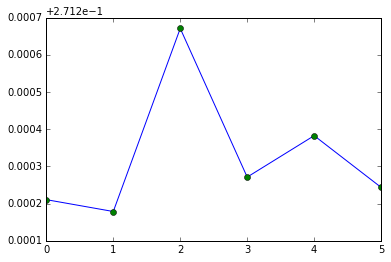

In [78]:
clusters = range(0,6,1)
silhouette = []

for num_clst in clusters:
    clst = cluster.k_means(df, 3)
    silhouette.append(metrics.silhouette_score(df, clst[1]))
    
plt.plot(clusters, silhouette)
plt.plot(clusters, silhouette, 'o')

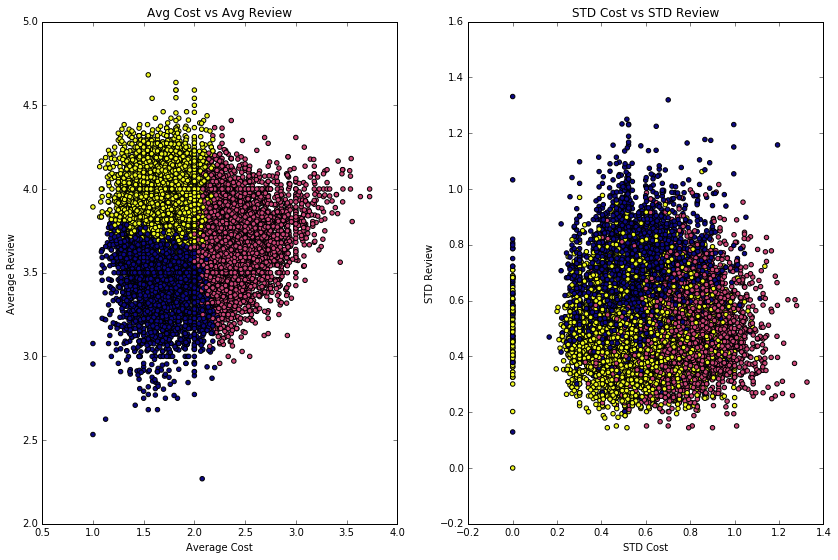

In [100]:
clst = cluster.k_means(df, 3)

cmap = plt.cm.plasma

plt.figure(figsize=(14,9))
plt.subplot(121)
plt.title('Avg Cost vs Avg Review')
plt.xlabel('Average Cost')
plt.ylabel('Average Review')
plt.scatter(df.avgcost, df.avgreview, c=clst[1], cmap=cmap)
plt.subplot(122)
plt.title('STD Cost vs STD Review')
plt.xlabel('STD Cost')
plt.ylabel('STD Review')
plt.scatter(df.stdcost, df.stdreview, c=clst[1],cmap=cmap)
#plt.savefig('/Users/josh/Desktop/cluster.pdf', format='pdf')

In [101]:
print clst[0]
print df.head(2)

[[ 3.52895372  0.63608047  1.71965659  0.54757728]
 [ 3.70454471  0.51161264  2.33413561  0.72299008]
 [ 3.89812944  0.49767663  1.75384003  0.54799002]]
   avgreview  stdreview   avgcost   stdcost
0   3.534483   0.549854  1.793103  0.726012
1   3.933333   0.457738  2.200000  0.414039


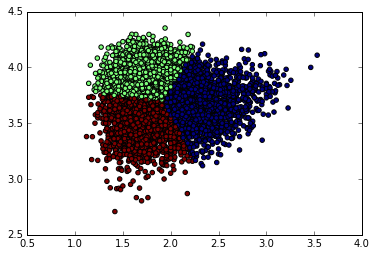

In [59]:
specClus = cluster.SpectralClustering(3)
labels   = specClus.fit_predict(df)

plt.scatter(df.avgcost, df.avgreview, c=labels)

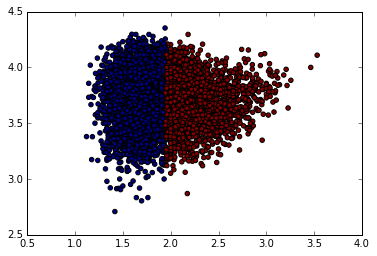

In [60]:
specClus = cluster.SpectralClustering(2)
labels   = specClus.fit_predict(df)

plt.scatter(df.avgcost, df.avgreview, c=labels)

In [102]:
df.shape

(30497, 4)

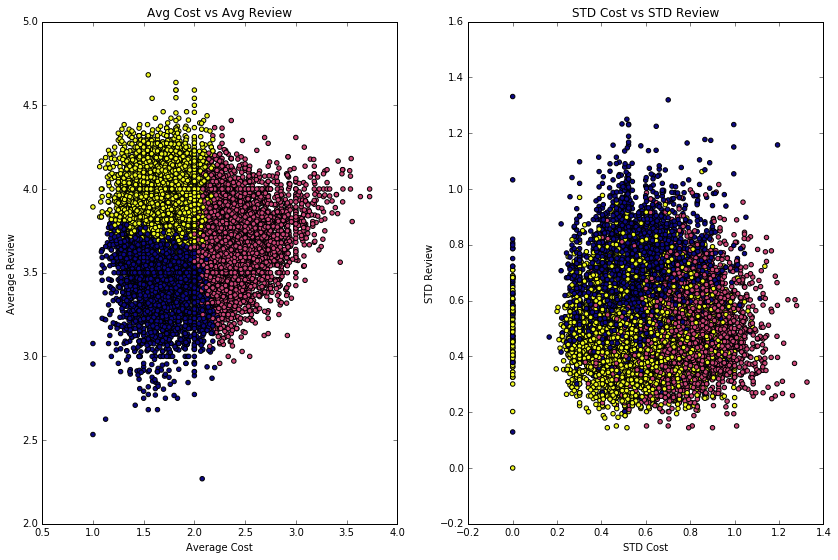

In [103]:
cmap = plt.cm.plasma

plt.figure(figsize=(14,9))
plt.subplot(121)
plt.title('Avg Cost vs Avg Review')
plt.xlabel('Average Cost')
plt.ylabel('Average Review')
plt.scatter(df.avgcost, df.avgreview, c=clst[1], cmap=cmap)
plt.subplot(122)
plt.title('STD Cost vs STD Review')
plt.xlabel('STD Cost')
plt.ylabel('STD Review')
plt.scatter(df.stdcost, df.stdreview, c=clst[1],cmap=cmap)
plt.savefig('/Users/josh/Desktop/cluster.png', format='png')

In [107]:
userName = 'who'

conn = sqlalchemy.create_engine('postgresql:///yelp')

qr = "SELECT review, price, fairness FROM users WHERE name = \'%s\'" % (userName)
df = pd.read_sql_query(qr, conn)
df.head()

,review,price,fairness


In [109]:
df.shape[0]

0

In [114]:
qr = "SELECT avgreview, avgcost, fairness FROM avg" 
df = pd.read_sql_query(qr, conn)
df.head()

,avgreview,avgcost,fairness
0,3.898129,1.753840,1.0
1,3.704545,2.334136,1.0
2,3.528954,1.719657,1.0


In [118]:
df.as_matrix()

array([[ 3.89812944,  1.75384003,  1.        ],
       [ 3.70454471,  2.33413561,  1.        ],
       [ 3.52895372,  1.71965659,  1.        ]])